In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [281]:
#setting directory
import os
os.chdir(r"F:\Courses\Intro to AI Health\Final Project\New folder")
path = os.getcwd()
print(path)
# reading the csv file
df = pd.read_csv('bio_chem_trimmed_chem_mental_synthetic.csv')

F:\Courses\Intro to AI Health\Final Project\New folder


In [282]:
print('Number of samples:',len(df))

Number of samples: 29063


In [283]:
# a brief look on the data
df.head()

,lbxsatsi,lbxsal,lbxscr,lbxsgl,lbxsch,lbxsir,lbxstr,lbxsapsi,lbxsassi,lbxsc3si,...,lbxsldsi,lbxsossi,lbxsph,lbxsksi,lbxsnasi,lbxstb,lbxsca,lbxstp,lbxsua,dpq020
0,16,4.4,0.92,85,157,94,95,74,20,31,...,174,280,4.0,4.0,141,0.6,9.2,7.3,5.8,0
1,10,4.4,0.81,94,149,163,92,79,14,28,...,142,286,4.0,4.4,144,0.7,9.6,7.1,8.0,0
2,19,3.9,0.58,116,210,96,72,66,21,27,...,247,289,3.3,4.4,144,0.5,9.5,7.1,4.5,0
3,20,4.0,1.13,98,239,57,59,56,23,29,...,139,280,3.4,4.9,140,0.3,9.4,7.1,4.2,0
4,46,4.8,0.77,81,185,225,124,99,35,31,...,144,281,5.1,4.3,141,0.8,9.6,8.1,5.8,0


In [284]:
# defining a function to calculate the prevalence of population that is readmitted with 30 days.
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [285]:
print('Prevalence:%.3f'%calc_prevalence(df['dpq020'].values))
# Around 11% of the population is rehospitalized

Prevalence:0.500


# Feature Engineering

In [286]:
# df_data.to_csv(r'F:\Courses\Intro to AI Health\Week 5\Assignment\Diabetes Risk Prediction of Patient Readmission - Using Python\df_data_final_use.csv')

In [287]:
df_data = df

col2use = df.columns.difference(['dpq020'])


# Building Training/Validation/Test Samples

In [288]:
# https://github.com/andrewwlong/diabetes_readmission/blob/master/diabetes_project.ipynb
# In this project, we will split into 70% train, 15% validation, 15% test.
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

# df_data.head()

In [289]:
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [290]:
# splitting into test and validation using 50% fraction.
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# .drop just drops the rows from df_test to get the rows that were not part of the sample.

In [291]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

In [292]:
# checking what percent of our groups are hospitalized within 30 days
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.dpq020.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.dpq020.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.dpq020.values)))

Test prevalence(n = 4360):0.509
Valid prevalence(n = 4359):0.503
Train all prevalence(n = 20344):0.498


In [293]:
# split the training data into positive and negative
rows_pos = df_train_all.dpq020 == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
# taken the length of positive data (smallest)
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.dpq020.values)))

Train balanced prevalence(n = 20244):0.500


In [294]:
# count_row = df_train_pos.shape[0]  # Gives number of rows
# count_col = df_train_pos.shape[1]  # Gives number of columns
# print(count_row)
# count_row = df_train_neg.shape[0]
# print(count_row)
# count_row = df_train.shape[0]
# print(count_row)

# df_train_pos.head()

In [295]:
# creating input matrix X and output vector y
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['dpq020'].values
y_valid = df_valid['dpq020'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (20344, 24)
Training shapes: (20244, 24) (20244,)
Validation shapes: (4359, 24) (4359,)


In [296]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [297]:
# saving scaler for the test data using a package called pickle
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [298]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [299]:
# transforming data matrices (not test matrix)
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

In [300]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [301]:
# because we have positive and negative
thresh = 0.5

In [302]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier()

In [303]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.797
accuracy:0.721
recall:0.629
precision:0.770
specificity:0.812
prevalence:0.500
 
Validation:
AUC:0.575
accuracy:0.552
recall:0.454
precision:0.568
specificity:0.652
prevalence:0.503
 


In [304]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [305]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.577
accuracy:0.558
recall:0.528
precision:0.561
specificity:0.587
prevalence:0.500
 
Validation:
AUC:0.579
accuracy:0.560
recall:0.530
precision:0.567
specificity:0.590
prevalence:0.503
 


In [306]:
# Stochastic gradient descent
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [307]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.575
accuracy:0.556
recall:0.528
precision:0.560
specificity:0.585
prevalence:0.500
 
Validation:
AUC:0.574
accuracy:0.557
recall:0.531
precision:0.563
specificity:0.583
prevalence:0.503
 


In [308]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [309]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.551
accuracy:0.514
recall:0.112
precision:0.573
specificity:0.917
prevalence:0.500
 
Validation:
AUC:0.555
accuracy:0.508
recall:0.112
precision:0.554
specificity:0.909
prevalence:0.503
 


In [310]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [311]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.783
accuracy:0.704
recall:0.590
precision:0.764
specificity:0.805
prevalence:0.500
 
Validation:
AUC:0.616
accuracy:0.599
recall:0.476
precision:0.634
specificity:0.710
prevalence:0.503
 


In [312]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [313]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.745
accuracy:0.677
recall:0.698
precision:0.670
specificity:0.656
prevalence:0.500
 
Validation:
AUC:0.683
accuracy:0.630
recall:0.655
precision:0.627
specificity:0.606
prevalence:0.503
 


In [314]:
# Gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [315]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)



Gradient Boosting Classifier
Training:
AUC:0.843
accuracy:0.758
recall:0.728
precision:0.775
specificity:0.789
prevalence:0.500
 
Validation:
AUC:0.725
accuracy:0.664
recall:0.633
precision:0.677
specificity:0.696
prevalence:0.503
 


# Analysis of baseline models

In [316]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")



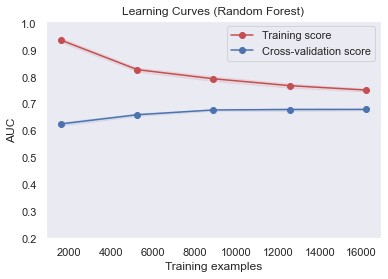

In [318]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

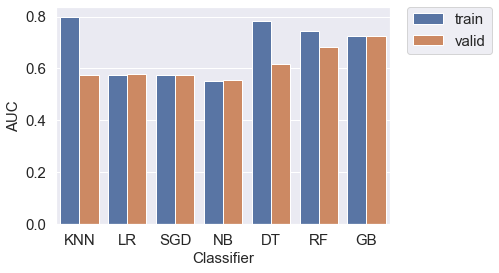

In [319]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [320]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

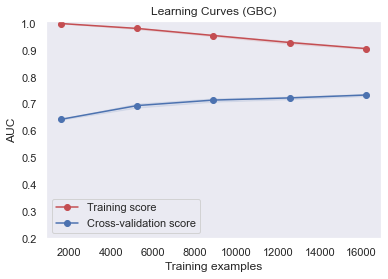

In [321]:
title = "Learning Curves (GBC)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = GradientBoostingClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

# Model Selection: Feature Importance

In [322]:
#getting the feature importance from logistic regression
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

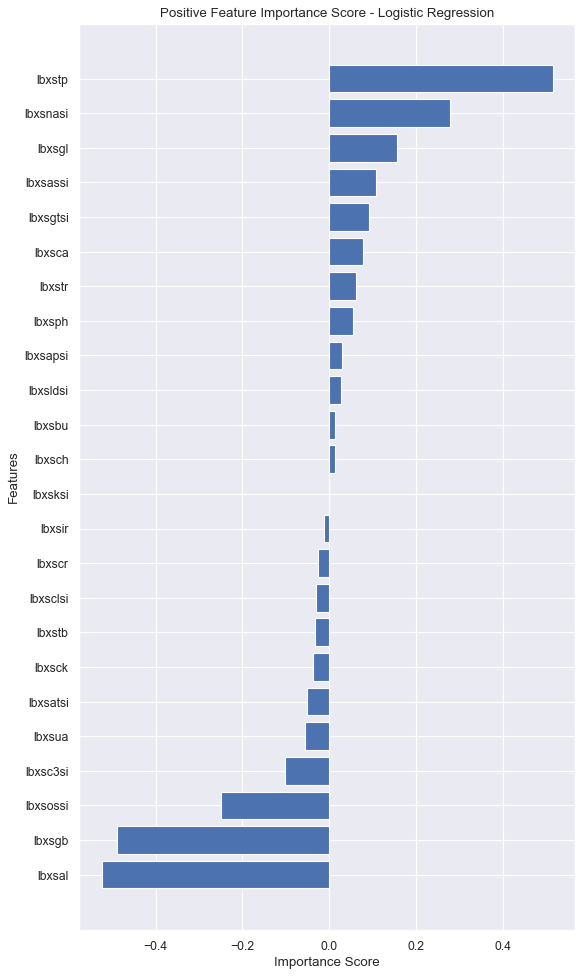

In [323]:
num = 24
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()



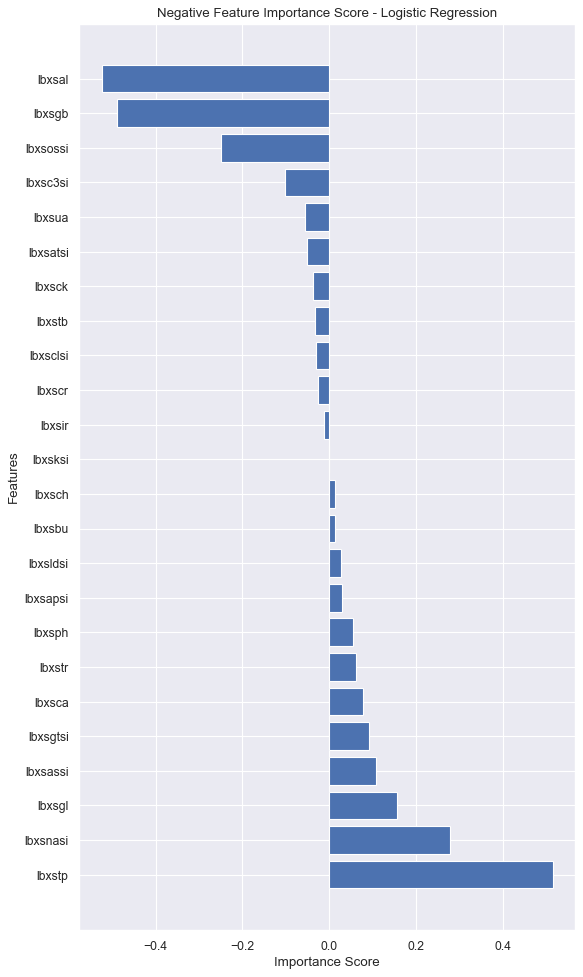

In [324]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

In [325]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

feature_importances_gbc = pd.DataFrame(gbc.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [326]:
feature_importances.head()


,importance
lbxsck,0.134529
lbxsatsi,0.098706
lbxscr,0.097454
lbxsua,0.077515
lbxsassi,0.062879


In [327]:
feature_importances_gbc.head()

,importance
lbxsatsi,0.152020
lbxscr,0.097815
lbxsassi,0.095495
lbxsck,0.076301
lbxsua,0.061085


# Model Selection: Hyperparameter Tuning

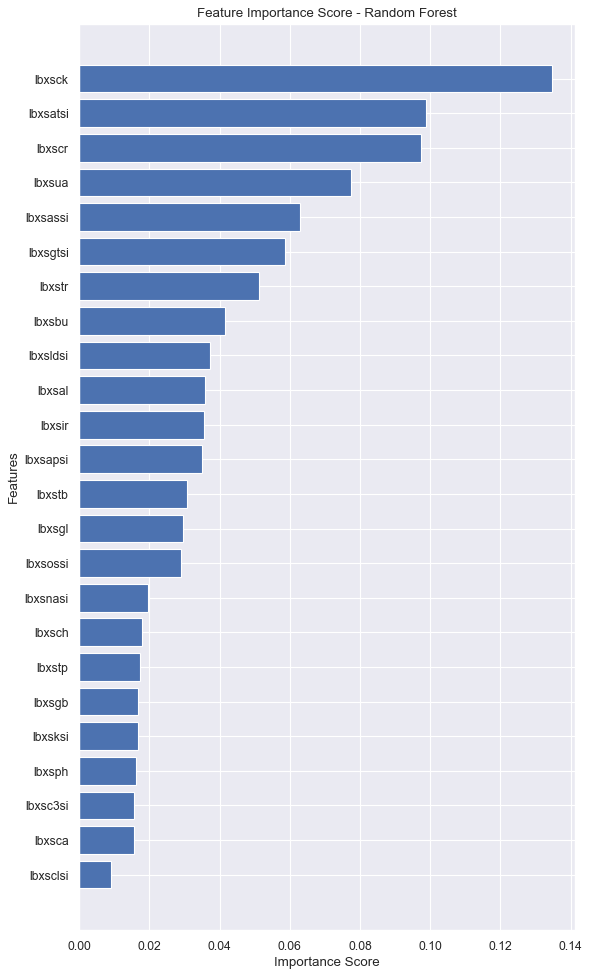

In [328]:
num = 24
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

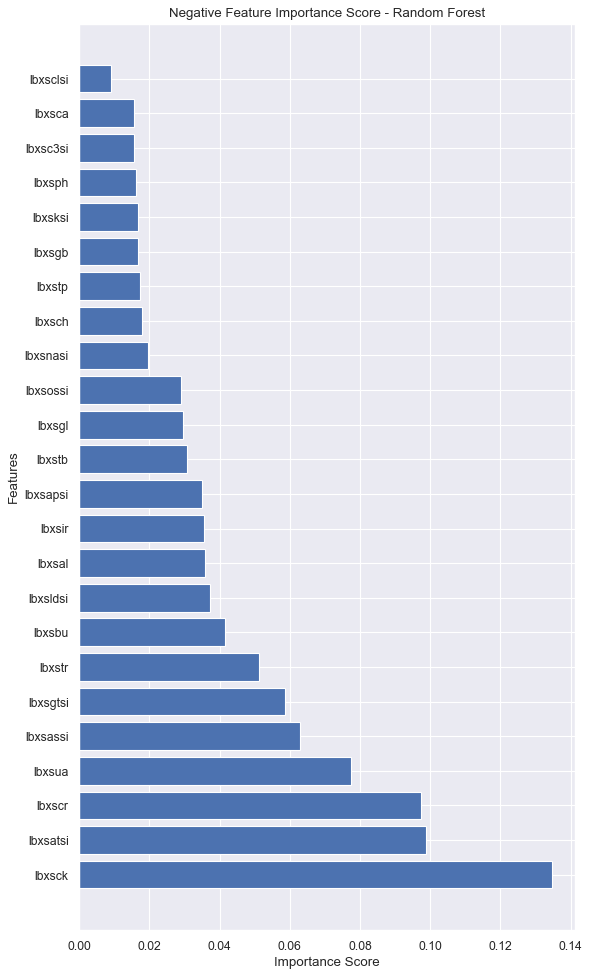

In [329]:
num = 24
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

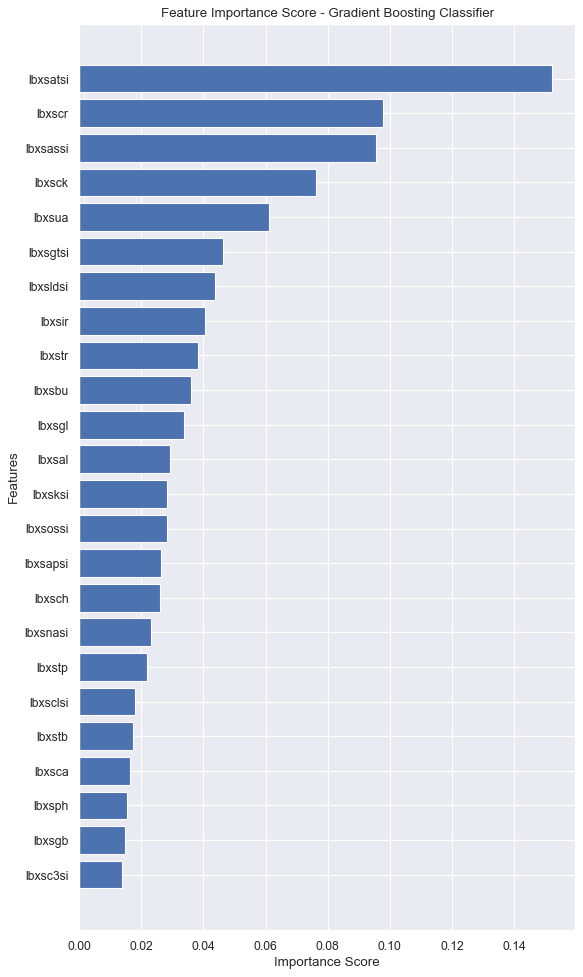

In [330]:
num = 24
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances_gbc.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances_gbc.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Gradient Boosting Classifier')
plt.yticks(ylocs, feature_labels)
plt.show()

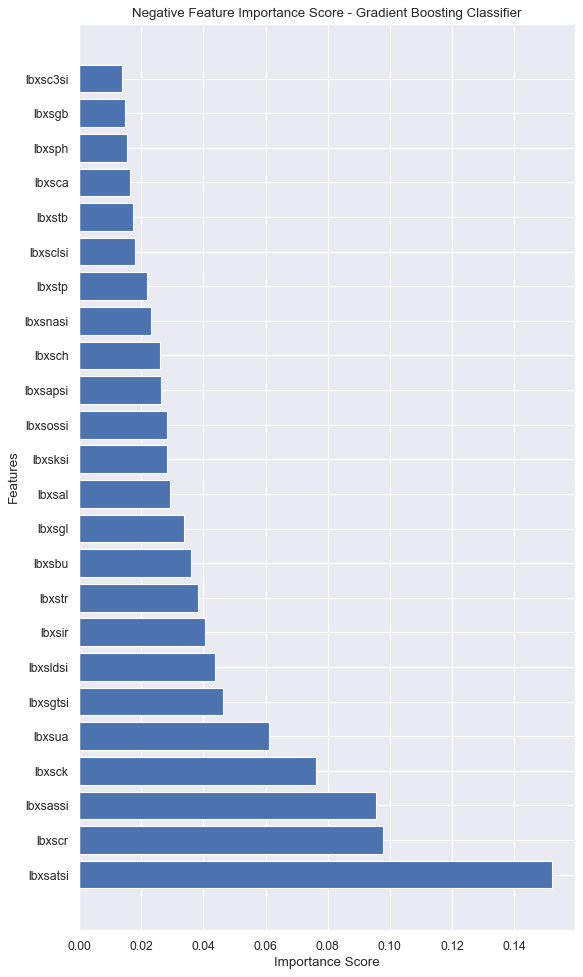

In [331]:

num = 24
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances_gbc.iloc[-num:].values.ravel()
feature_labels = list(feature_importances_gbc.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Gradient Boosting Classifier')
plt.yticks(ylocs, feature_labels)
plt.show()

In [332]:
# creating a grid over a few of the random forest hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [333]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [334]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [335]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.8min finished


184.60673308372498


In [336]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'criterion': 'gini'}

In [337]:
# analyzing the performance of the best model compared to the baseline model
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.745
Validation AUC:0.683
Optimized Random Forest
Training AUC:0.868
Validation AUC:0.711


In [338]:
# optimizing the performance of stochastic gradient descent classifier
penalty = ['none','l2','l1']
max_iter = range(100,500,100)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, 
                                 n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, 
                                 random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

1.269604206085205


In [339]:
sgdc_random.best_params_

{'penalty': 'none', 'max_iter': 400, 'alpha': 0.01}

In [340]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Baseline sgdc')
sgdc_train_auc_base = roc_auc_score(y_train, y_train_preds)
sgdc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_auc_base))
print('Validation AUC:%.3f'%(sgdc_valid_auc_base))
print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_auc))
print('Validation AUC:%.3f'%(sgdc_valid_auc))

Baseline sgdc
Training AUC:0.575
Validation AUC:0.574
Optimized sgdc
Training AUC:0.574
Validation AUC:0.578


In [341]:
# optimize the performance of gradient boosting classifier
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

236.72844791412354


In [342]:
gbc_random.best_params_

{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1}

In [343]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.843
Validation AUC:0.725
Optimized gbc
Training AUC:0.822
Validation AUC:0.735


In [344]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB'],
                           'data_set':['base','optimized']*3,
                          'auc':[sgdc_valid_auc_base,sgdc_valid_auc,
                                 rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,],
                          })

In [345]:
df_results

,classifier,data_set,auc
0,SGD,base,0.574152
1,SGD,optimized,0.577701
2,RF,base,0.683117
3,RF,optimized,0.711258
4,GB,base,0.725345
5,GB,optimized,0.734692


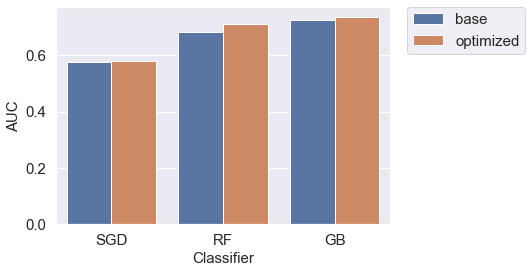

In [346]:
# comparing to the baseline models on the validation set
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

# Model Selection: Best Classifier

In [347]:
# saving the best classifier
pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

In [348]:
# Model Evaluation

In [349]:
X_test = df_test[col2use].values
y_test = df_test['dpq020'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [350]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [351]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [352]:
# Final evaluation
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.822
accuracy:0.741
recall:0.699
precision:0.764
specificity:0.784
prevalence:0.500
 
Validation:
AUC:0.735
accuracy:0.670
recall:0.629
precision:0.687
specificity:0.710
prevalence:0.503
 
Test:
AUC:0.719
accuracy:0.661
recall:0.628
precision:0.681
specificity:0.695
prevalence:0.509
 


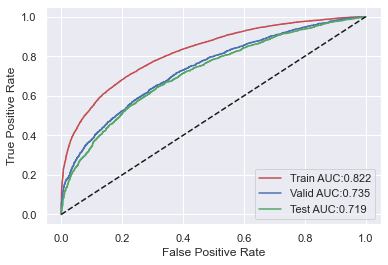

In [353]:
# ROC curve for the 3 datasets
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()